# Feature selection (Colab)

In [1]:
import tensorflow as tf
tf.test.is_gpu_available() # True/False

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls

drive  sample_data


In [4]:
import os
os.chdir('drive/My Drive/Github/fpl-analysis')

In [5]:
!pip install tensorflow==2.1.0
!pip install numpy==1.18.1
!pip install pyarrow==0.15.0
!pip install s3fs==0.4.0
!pip install matplotlib==3.1.1
!pip install seaborn==0.10.0
!pip install keras==2.3.1
!pip install scikit-learn==0.22.1

  Using cached https://files.pythonhosted.org/packages/af/60/455bfa3d2289339789b5ae00ab4afc88d799298f8e24ffdcd9419d177997/pyarrow-0.15.0-cp36-cp36m-manylinux2010_x86_64.whl
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1
  Found existing installation: s3fs 0.4.2
    Uninstalling s3fs-0.4.2:
      Successfully uninstalled s3fs-0.4.2
     |████████████████████████████████| 13.1MB 239kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


     |████████████████████████████████| 225kB 2.8MB/s eta 0:00:01
  Found existing installation: seaborn 0.10.1
    Uninstalling seaborn-0.10.1:
      Successfully uninstalled seaborn-0.10.1
     |████████████████████████████████| 378kB 2.7MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 7.1MB 2.7MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


## 0. Set-up

In [1]:
import os
import getpass

import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from s3fs import S3FileSystem
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model, Model
from keras.layers import Dense, Flatten, LSTM, BatchNormalization, Input, Dropout, Activation, Bidirectional
from keras import initializers, optimizers, Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from hyperopt import hp, fmin, rand, tpe, Trials

Using TensorFlow backend.


In [4]:
from src.models.utils import \
    _load_all_historical_data, \
    _map_season_string_to_ordered_numeric, \
    _generate_known_features_for_next_gw, \
    custom_train_test_split, \
    split_sequences
from src.visualisation.utils import plot_learning_curve

In [5]:
pd.options.display.max_columns = None

In [6]:
RANDOM_SEED = 3
N_STEPS_IN = 5
N_STEPS_OUT = 5

In [7]:
AWS_ACCESS_KEY_ID = getpass.getpass()
AWS_SECRET_KEY = getpass.getpass()

 ····················
 ········································


In [8]:
s3_filesystem = S3FileSystem(
    key=AWS_ACCESS_KEY_ID,
    secret=AWS_SECRET_KEY
)

## 1. Preprocessing

### Load FFS data

In [9]:
ffs_all_data = pq.read_table(
    f"s3://fantasy-football-scout/processed/fantasy_football_scout_final_features_and_total_points.parquet", 
    filesystem=s3_filesystem
).to_pandas()

print(ffs_all_data.shape)
ffs_all_data.head()

(92410, 55)


,Name,Team,Aerial Duels - Won - Percentage,Assists,Big Chances Created,Caught Offside,Chances Created (Right Zone),Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,position,full_name,season,gw,Distribution - Unsuccessful,Dribbles - Successful Percentage,Goal Kicks,Goals,Goals Conceded,Goals From Penalties,Ground Duels Lost,Handballs,ICT Influence,Minutes Per Save,Minutes Per Touch,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes - Final Third - Unsuccessful,Passes - Forward - Successful,Passes - Opponents Half - Centre - Unsuccessful,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Saves,Shots - Inside Box,Shots - Long - Attempts,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Take Ons,Take Ons - Successful Percentage,Time Played,Own Goals,Penalties Missed,Premier League Yellow Cards,Saves From Penalty,Touches - Opponents Half - Right,Touches - Penalty Area,xGI Expected Goal Involvement,name,total_points
0,van Persie,ARS,75.0,0,0,1,0,0,1,0,5,0,FWD,Robin van Persie,2011-2012,1,0,100.0,0,0,0,0,0,0,6,0.0,2.1,71,75,75,2,8,3,0,0,1,0,1,0,0,0,0,0.0,1,100.0,90,0,0,0,0,8,7,0.0,robin_van persie,2
1,Zamora,QPR,40.0,0,0,2,0,0,1,0,0,0,FWD,Bobby Zamora,2011-2012,1,0,50.0,0,0,0,0,1,0,10,0.0,2.0,59,67,63,4,7,8,0,0,3,0,4,0,3,1,0,0.0,2,50.0,74,0,0,0,0,7,6,0.0,bobby_zamora,2
2,Gervinho,ARS,0.0,0,0,0,1,1,1,1,4,0,FWD,Gervais Yao Kouassi,2011-2012,1,0,80.0,0,0,0,0,1,0,7,0.0,1.7,79,73,76,6,8,6,1,1,4,0,1,0,0,0,0,0.0,5,80.0,76,0,0,0,0,8,12,0.0,gervais_yao kouassi,-1
3,Welbeck,MUN,0.0,0,0,0,0,0,0,0,0,0,FWD,Danny Welbeck,2011-2012,1,0,0.0,0,0,1,0,3,0,3,0.0,2.3,68,50,60,6,3,5,0,0,2,0,0,0,0,1,0,66.7,1,0.0,65,0,0,0,0,1,3,0.0,danny_welbeck,2
4,Torres,CHE,0.0,0,1,2,1,0,1,1,2,0,FWD,Fernando Torres,2011-2012,1,0,55.6,0,0,0,0,6,0,10,0.0,1.4,75,68,70,6,9,8,0,0,4,0,3,0,1,1,0,50.0,9,55.6,89,0,0,0,0,6,9,0.0,fernando_torres,2


In [10]:
ffs_all_data.drop(columns=['Name', 'full_name'], inplace=True)

### Deal with nulls and inf values

Columns previously identified as containing `inf` values are no longer in the feature set:

- 'Minutes Per xA'
- 'Minutes Per xG'
- 'Minutes Per xGI'
- 'Minutes Per xGP'
- 'Sky Minutes Per Bonus'


nan

In [11]:
(ffs_all_data == 'nan').sum().sum()

/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


0

### Add 0 minute events back into data

FFS data only includes players who played > 0 minutes. Therefore if a player is benched one gameweek then they wouldn't appear in the data although we would like to train our model on these cases.

We therefore create a 'master' DataFrame of all unique names and all possible season and gameweek combinations. We then left join the FFS data and fill in nulls with zeros.

Note: We make sure to only add missing gameweeks for seasons in which the player played in the Premier League.

In [12]:
ffs_all_data['season'].unique()

array(['2011-2012', '2012-2013', '2013-2014', '2014-2015', '2015-2016',
       '2016-2017', '2017-2018', '2018-2019', '2019-2020'], dtype=object)

In [13]:
ffs_data_names = ffs_all_data[['name', 'Team', 'position', 'season']].drop_duplicates()
ffs_data_names['key'] = 1
print(ffs_data_names.shape)
ffs_data_names.head()

(4746, 5)


,name,Team,position,season,key
0,robin_van persie,ARS,FWD,2011-2012,1
1,bobby_zamora,QPR,FWD,2011-2012,1
2,gervais_yao kouassi,ARS,FWD,2011-2012,1
3,danny_welbeck,MUN,FWD,2011-2012,1
4,fernando_torres,CHE,FWD,2011-2012,1


In [14]:
gw_df = pd.DataFrame({'gw': range(1, 39)})
gw_df['key'] = 1
gw_df.head()

,gw,key
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [15]:
all_player_season_gw_df = gw_df.merge(ffs_data_names, on='key')
all_player_season_gw_df.drop('key', axis=1, inplace=True)
all_player_season_gw_df.shape

(180348, 5)

In [16]:
all_player_season_gw_df.head()

,gw,name,Team,position,season
0,1,robin_van persie,ARS,FWD,2011-2012
1,1,bobby_zamora,QPR,FWD,2011-2012
2,1,gervais_yao kouassi,ARS,FWD,2011-2012
3,1,danny_welbeck,MUN,FWD,2011-2012
4,1,fernando_torres,CHE,FWD,2011-2012


In [17]:
all_player_season_gw_df.sort_values(['name', 'season', 'gw'], inplace=True)

In [18]:
all_player_season_gw_df.head()

,gw,name,Team,position,season
822,1,aaron_connolly,BHA,FWD,2019-2020
5568,2,aaron_connolly,BHA,FWD,2019-2020
10314,3,aaron_connolly,BHA,FWD,2019-2020
15060,4,aaron_connolly,BHA,FWD,2019-2020
19806,5,aaron_connolly,BHA,FWD,2019-2020


__Note:__ There is a risk that we have added gameweeks for players who only joined their club mid season. Ideally we should remove these.

In [19]:
mid_season_transfers = pd.read_csv('data/external/mid_season_transfers_2016_to_2019.csv')
print(mid_season_transfers.shape)
mid_season_transfers.head()

(43, 5)


,name,transfer_date,old_team,new_team,season
0,aaron_lennon,2018-01-23,Everton,Burnley,2017-18
1,adlène_guédioura,2017-01-31,Watford,Middlesbrough,2016-17
2,alex_oxlade-chamberlain,2017-08-31,Arsenal,Liverpool,2017-18
3,alexis_sánchez,2018-01-22,Arsenal,Manchester United,2017-18
4,andré_ayew,2018-01-31,West Ham United,Swansea City,2017-18


Our mid season dataset only covers 3 seasons (16/17 to 18/19), does not specify gameweek and only looks at changes between PL clubs. It would take a considerable amount of work to get this information so we accept this slight deficiency in the data. It only adds additional 0 events and hopefully shouldn't impact performance greatly.

In [20]:
ffs_data = all_player_season_gw_df.merge(ffs_all_data, on=['name', 'Team', 'position', 'gw', 'season'], how='left', indicator=True)
print(ffs_data.shape)
ffs_data.head()

(180348, 54)


,gw,name,Team,position,season,Aerial Duels - Won - Percentage,Assists,Big Chances Created,Caught Offside,Chances Created (Right Zone),Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Distribution - Unsuccessful,Dribbles - Successful Percentage,Goal Kicks,Goals,Goals Conceded,Goals From Penalties,Ground Duels Lost,Handballs,ICT Influence,Minutes Per Save,Minutes Per Touch,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes - Final Third - Unsuccessful,Passes - Forward - Successful,Passes - Opponents Half - Centre - Unsuccessful,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Saves,Shots - Inside Box,Shots - Long - Attempts,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Take Ons,Take Ons - Successful Percentage,Time Played,Own Goals,Penalties Missed,Premier League Yellow Cards,Saves From Penalty,Touches - Opponents Half - Right,Touches - Penalty Area,xGI Expected Goal Involvement,total_points,_merge
0,1,aaron_connolly,BHA,FWD,2019-2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,2,aaron_connolly,BHA,FWD,2019-2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,3,aaron_connolly,BHA,FWD,2019-2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,4,aaron_connolly,BHA,FWD,2019-2020,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,100.0,0.0,100.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,both
4,5,aaron_connolly,BHA,FWD,2019-2020,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,2.0,0.14,1.0,both


In [21]:
ffs_data['_merge'].value_counts()

both          92410
left_only     87938
right_only        0
Name: _merge, dtype: int64

In [22]:
ffs_data.drop(columns='_merge', inplace=True)

In [23]:
ffs_data.sort_values(['name', 'season', 'gw'], inplace=True)
ffs_data.head()

,gw,name,Team,position,season,Aerial Duels - Won - Percentage,Assists,Big Chances Created,Caught Offside,Chances Created (Right Zone),Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Distribution - Unsuccessful,Dribbles - Successful Percentage,Goal Kicks,Goals,Goals Conceded,Goals From Penalties,Ground Duels Lost,Handballs,ICT Influence,Minutes Per Save,Minutes Per Touch,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes - Final Third - Unsuccessful,Passes - Forward - Successful,Passes - Opponents Half - Centre - Unsuccessful,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Saves,Shots - Inside Box,Shots - Long - Attempts,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Take Ons,Take Ons - Successful Percentage,Time Played,Own Goals,Penalties Missed,Premier League Yellow Cards,Saves From Penalty,Touches - Opponents Half - Right,Touches - Penalty Area,xGI Expected Goal Involvement,total_points
0,1,aaron_connolly,BHA,FWD,2019-2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,aaron_connolly,BHA,FWD,2019-2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,aaron_connolly,BHA,FWD,2019-2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,aaron_connolly,BHA,FWD,2019-2020,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,100.0,0.0,100.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0
4,5,aaron_connolly,BHA,FWD,2019-2020,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,2.0,0.14,1.0


In [24]:
ffs_data.isnull().sum()

gw                                                     0
name                                                   0
Team                                                   0
position                                               0
season                                                 0
Aerial Duels - Won - Percentage                    87938
Assists                                            87938
Big Chances Created                                87938
Caught Offside                                     87938
Chances Created (Right Zone)                       87938
Chances From Counter Attack                        87938
Clean Sheets                                       87938
Crosses - Open Play - Successful                   87938
Crosses - Unsuccessful                             87938
Distribution - Successful                          87938
Distribution - Unsuccessful                        87938
Dribbles - Successful Percentage                   87938
Goal Kicks                     

In [25]:
# From an offline check the missing entries are 0 minutes players in a given GW. We can therefore fill all missing data points with 0.
ffs_data.fillna(0, inplace=True)

### Position dummies

In [26]:
ffs_data = pd.get_dummies(ffs_data, columns=['position'])

In [27]:
ffs_data.rename(columns={'Team': 'team_name'}, inplace=True)

### Merge fixture and odds data

Merging fixture data also serves another purpose. In the previous step we created _all_ possible gameweek-player combinations. However, due to double gameweeks there are many cases where a player simply would not feature in a given gameweek and in this case we want to remove that player-gameweek for the data. An inner join to fixtures data does this.

In [28]:
fixture_and_odds_features = pd.read_parquet('data/processed/formatted_fixture_and_odds_features_2011_to_2020.parquet')
print(fixture_and_odds_features.shape)
fixture_and_odds_features.head()

(6650, 19)


,season,gw,team_name,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,double_gameweek,next_gameweek_draw_odds,next_gameweek_win_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_double_gameweek
0,2011-2012,1,Arsenal,2.31,1.12,2.46,0.0,0,0,0,1,0,2.26,1.32,2.09,1.0,0.0,1.0,0.0
1,2011-2012,2,Arsenal,2.26,1.32,2.09,1.0,0,1,0,1,0,3.93,7.28,0.36,0.0,0.0,1.0,0.0
2,2011-2012,3,Arsenal,3.93,7.28,0.36,0.0,0,1,0,1,0,3.63,0.36,8.10,1.0,1.0,0.0,0.0
3,2011-2012,4,Arsenal,3.63,0.36,8.10,1.0,1,0,0,1,0,2.38,1.00,2.79,0.0,0.0,0.0,0.0
4,2011-2012,5,Arsenal,2.38,1.00,2.79,0.0,0,0,0,1,0,3.75,0.36,7.63,1.0,0.0,0.0,0.0


### Format FFS team names and seasons to match

In [29]:
ffs_data.head()

,gw,name,team_name,season,Aerial Duels - Won - Percentage,Assists,Big Chances Created,Caught Offside,Chances Created (Right Zone),Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Distribution - Unsuccessful,Dribbles - Successful Percentage,Goal Kicks,Goals,Goals Conceded,Goals From Penalties,Ground Duels Lost,Handballs,ICT Influence,Minutes Per Save,Minutes Per Touch,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes - Final Third - Unsuccessful,Passes - Forward - Successful,Passes - Opponents Half - Centre - Unsuccessful,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Saves,Shots - Inside Box,Shots - Long - Attempts,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Take Ons,Take Ons - Successful Percentage,Time Played,Own Goals,Penalties Missed,Premier League Yellow Cards,Saves From Penalty,Touches - Opponents Half - Right,Touches - Penalty Area,xGI Expected Goal Involvement,total_points,position_DEF,position_FWD,position_GK,position_MID
0,1,aaron_connolly,BHA,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0,1,0,0
1,2,aaron_connolly,BHA,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0,1,0,0
2,3,aaron_connolly,BHA,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0,1,0,0
3,4,aaron_connolly,BHA,2019-2020,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,100.0,0.0,100.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0,1,0,0
4,5,aaron_connolly,BHA,2019-2020,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,2.0,0.14,1.0,0,1,0,0


In [30]:
ffs_abbreviation_to_full = {
    'WHU': 'West Ham United', 
    'BUR': 'Burnley', 
    'HUD': 'Huddersfield Town', 
    'ARS': 'Arsenal', 
    'CRY': 'Crystal Palace', 
    'WAT': 'Watford', 
    'FUL': 'Fulham', 
    'LIV': 'Liverpool', 
    'BOU': 'Bournemouth',
    'WOL': 'Wolverhampton Wanderers', 
    'EVE': 'Everton', 
    'LEI': 'Leicester City', 
    'WBA': 'West Bromwich Albion', 
    'NEW': 'Newcastle United', 
    'SOU': 'Southampton', 
    'MUN': 'Manchester United', 
    'SWA': 'Swansea City', 
    'BHA': 'Brighton and Hove Albion',
    'CHE': 'Chelsea',
    'CAR': 'Cardiff City',
    'MCI': 'Manchester City',
    'TOT': 'Tottenham Hotspur',
    'STK': 'Stoke City',
    'AVL': 'Aston Villa',
    'BLA': 'Blackburn Rovers',
    'BOL': 'Bolton Wanderers',
    'HUL': 'Hull City',
    'MID': 'Middlesbrough',
    'NOR': 'Norwich City',
    'QPR': 'Queens Park Rangers',
    'RDG': 'Reading',
    'SHU': 'Sheffield United',
    'SUN': 'Sunderland',
    'WIG': 'Wigan Athletic'
}

In [31]:
set(ffs_data['team_name'].replace(ffs_abbreviation_to_full)) - set(fixture_and_odds_features['team_name'])

set()

In [32]:
set(fixture_and_odds_features['team_name']) - set(ffs_data['team_name'].replace(ffs_abbreviation_to_full))

set()

In [33]:
ffs_data['team_name'].replace(ffs_abbreviation_to_full, inplace=True)

In [34]:
ffs_data.head()

,gw,name,team_name,season,Aerial Duels - Won - Percentage,Assists,Big Chances Created,Caught Offside,Chances Created (Right Zone),Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Distribution - Unsuccessful,Dribbles - Successful Percentage,Goal Kicks,Goals,Goals Conceded,Goals From Penalties,Ground Duels Lost,Handballs,ICT Influence,Minutes Per Save,Minutes Per Touch,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes - Final Third - Unsuccessful,Passes - Forward - Successful,Passes - Opponents Half - Centre - Unsuccessful,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Saves,Shots - Inside Box,Shots - Long - Attempts,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Take Ons,Take Ons - Successful Percentage,Time Played,Own Goals,Penalties Missed,Premier League Yellow Cards,Saves From Penalty,Touches - Opponents Half - Right,Touches - Penalty Area,xGI Expected Goal Involvement,total_points,position_DEF,position_FWD,position_GK,position_MID
0,1,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0,1,0,0
1,2,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0,1,0,0
2,3,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0,1,0,0
3,4,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,100.0,0.0,100.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0,1,0,0
4,5,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,2.0,0.14,1.0,0,1,0,0


In [35]:
ffs_data.shape

(180348, 56)

### Combine feature and odds features

In [36]:
fixture_and_odds_features.head()

,season,gw,team_name,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,double_gameweek,next_gameweek_draw_odds,next_gameweek_win_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_double_gameweek
0,2011-2012,1,Arsenal,2.31,1.12,2.46,0.0,0,0,0,1,0,2.26,1.32,2.09,1.0,0.0,1.0,0.0
1,2011-2012,2,Arsenal,2.26,1.32,2.09,1.0,0,1,0,1,0,3.93,7.28,0.36,0.0,0.0,1.0,0.0
2,2011-2012,3,Arsenal,3.93,7.28,0.36,0.0,0,1,0,1,0,3.63,0.36,8.10,1.0,1.0,0.0,0.0
3,2011-2012,4,Arsenal,3.63,0.36,8.10,1.0,1,0,0,1,0,2.38,1.00,2.79,0.0,0.0,0.0,0.0
4,2011-2012,5,Arsenal,2.38,1.00,2.79,0.0,0,0,0,1,0,3.75,0.36,7.63,1.0,0.0,0.0,0.0


In [37]:
ffs_data.head()

,gw,name,team_name,season,Aerial Duels - Won - Percentage,Assists,Big Chances Created,Caught Offside,Chances Created (Right Zone),Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Distribution - Unsuccessful,Dribbles - Successful Percentage,Goal Kicks,Goals,Goals Conceded,Goals From Penalties,Ground Duels Lost,Handballs,ICT Influence,Minutes Per Save,Minutes Per Touch,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes - Final Third - Unsuccessful,Passes - Forward - Successful,Passes - Opponents Half - Centre - Unsuccessful,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Saves,Shots - Inside Box,Shots - Long - Attempts,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Take Ons,Take Ons - Successful Percentage,Time Played,Own Goals,Penalties Missed,Premier League Yellow Cards,Saves From Penalty,Touches - Opponents Half - Right,Touches - Penalty Area,xGI Expected Goal Involvement,total_points,position_DEF,position_FWD,position_GK,position_MID
0,1,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0,1,0,0
1,2,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0,1,0,0
2,3,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0,1,0,0
3,4,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,100.0,0.0,100.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0,1,0,0
4,5,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,2.0,0.14,1.0,0,1,0,0


In [38]:
# Inner join also removes gw-season fixtures which did not happen but were filled with 0s
print(ffs_data.shape)

ffs_data = ffs_data.merge(
    fixture_and_odds_features, 
    on=['season', 'gw', 'team_name'], 
    how='inner'
)

print(ffs_data.shape)

ffs_data.head()

(180348, 56)
(175365, 72)


,gw,name,team_name,season,Aerial Duels - Won - Percentage,Assists,Big Chances Created,Caught Offside,Chances Created (Right Zone),Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Distribution - Unsuccessful,Dribbles - Successful Percentage,Goal Kicks,Goals,Goals Conceded,Goals From Penalties,Ground Duels Lost,Handballs,ICT Influence,Minutes Per Save,Minutes Per Touch,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes - Final Third - Unsuccessful,Passes - Forward - Successful,Passes - Opponents Half - Centre - Unsuccessful,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Saves,Shots - Inside Box,Shots - Long - Attempts,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Take Ons,Take Ons - Successful Percentage,Time Played,Own Goals,Penalties Missed,Premier League Yellow Cards,Saves From Penalty,Touches - Opponents Half - Right,Touches - Penalty Area,xGI Expected Goal Involvement,total_points,position_DEF,position_FWD,position_GK,position_MID,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,double_gameweek,next_gameweek_draw_odds,next_gameweek_win_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_double_gameweek
0,1,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,2.29,3.09,1.08,0.0,0,0,0,0,0,2.45,1.21,2.41,1.0,0.0,0.0,0.0
1,1,aaron_mooy,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,2.29,3.09,1.08,0.0,0,0,0,0,0,2.45,1.21,2.41,1.0,0.0,0.0,0.0
2,1,adam_webster,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,2.29,3.09,1.08,0.0,0,0,0,0,0,2.45,1.21,2.41,1.0,0.0,0.0,0.0
3,1,alexis_mac allister,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,2.29,3.09,1.08,0.0,0,0,0,0,0,2.45,1.21,2.41,1.0,0.0,0.0,0.0
4,1,alireza_jahanbakhsh,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,2.29,3.09,1.08,0.0,0,0,0,0,0,2.45,1.21,2.41,1.0,0.0,0.0,0.0


In [39]:
ffs_data[
    (ffs_data['season'] == '2017-2018') & (ffs_data['gw'] == 36) & (ffs_data['team_name'] == 'Arsenal')
].head()

,gw,name,team_name,season,Aerial Duels - Won - Percentage,Assists,Big Chances Created,Caught Offside,Chances Created (Right Zone),Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Distribution - Unsuccessful,Dribbles - Successful Percentage,Goal Kicks,Goals,Goals Conceded,Goals From Penalties,Ground Duels Lost,Handballs,ICT Influence,Minutes Per Save,Minutes Per Touch,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes - Final Third - Unsuccessful,Passes - Forward - Successful,Passes - Opponents Half - Centre - Unsuccessful,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Saves,Shots - Inside Box,Shots - Long - Attempts,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Take Ons,Take Ons - Successful Percentage,Time Played,Own Goals,Penalties Missed,Premier League Yellow Cards,Saves From Penalty,Touches - Opponents Half - Right,Touches - Penalty Area,xGI Expected Goal Involvement,total_points,position_DEF,position_FWD,position_GK,position_MID,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,double_gameweek,next_gameweek_draw_odds,next_gameweek_win_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_double_gameweek
29908,36,aaron_ramsey,Arsenal,2017-2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0,0,0,1,4.35,7.18,0.39,0.0,0,1,0,1,0,3.4,0.695,4.86,1.0,0.0,0.0,1.0
29909,36,ainsley_maitland-niles,Arsenal,2017-2018,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.7,0.0,0.0,2.0,0.0,3.0,0.0,23.0,0.0,1.6,92.0,71.0,86.0,2.0,19.0,1.0,0.0,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,75.0,3.0,66.7,90.0,0.0,0.0,0.0,0.0,4.0,4.0,0.11,2.0,0,0,0,1,4.35,7.18,0.39,0.0,0,1,0,1,0,3.4,0.695,4.86,1.0,0.0,0.0,1.0
29910,36,alex_iwobi,Arsenal,2017-2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.7,0.0,0.0,2.0,0.0,2.0,0.0,10.0,0.0,1.7,93.0,78.0,88.0,2.0,22.0,3.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,66.7,3.0,66.7,90.0,0.0,0.0,0.0,0.0,5.0,0.0,0.03,2.0,0,0,0,1,4.35,7.18,0.39,0.0,0,1,0,1,0,3.4,0.695,4.86,1.0,0.0,0.0,1.0
29911,36,alexandre_lacazette,Arsenal,2017-2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0,1,0,0,4.35,7.18,0.39,0.0,0,1,0,1,0,3.4,0.695,4.86,1.0,0.0,0.0,1.0
29912,36,calum_chambers,Arsenal,2017-2018,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,2.0,0.0,2.0,0.0,38.0,0.0,1.3,71.0,0.0,100.0,0.0,22.0,5.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,75.0,1.0,100.0,90.0,0.0,0.0,0.0,0.0,6.0,1.0,0.00,1.0,1,0,0,0,4.35,7.18,0.39,0.0,0,1,0,1,0,3.4,0.695,4.86,1.0,0.0,0.0,1.0


In [40]:
ffs_data[
    (ffs_data['season'] == '2017-2018') & (ffs_data['gw'] == 37) & (ffs_data['team_name'] == 'Arsenal')
].head()

,gw,name,team_name,season,Aerial Duels - Won - Percentage,Assists,Big Chances Created,Caught Offside,Chances Created (Right Zone),Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Distribution - Unsuccessful,Dribbles - Successful Percentage,Goal Kicks,Goals,Goals Conceded,Goals From Penalties,Ground Duels Lost,Handballs,ICT Influence,Minutes Per Save,Minutes Per Touch,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes - Final Third - Unsuccessful,Passes - Forward - Successful,Passes - Opponents Half - Centre - Unsuccessful,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Saves,Shots - Inside Box,Shots - Long - Attempts,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Take Ons,Take Ons - Successful Percentage,Time Played,Own Goals,Penalties Missed,Premier League Yellow Cards,Saves From Penalty,Touches - Opponents Half - Right,Touches - Penalty Area,xGI Expected Goal Involvement,total_points,position_DEF,position_FWD,position_GK,position_MID,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,double_gameweek,next_gameweek_draw_odds,next_gameweek_win_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_double_gameweek
29934,37,aaron_ramsey,Arsenal,2017-2018,100.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,100.0,0.0,0.0,3.0,0.0,2.0,0.0,20.0,0.0,1.1,84.0,93.0,88.0,2.0,27.0,5.0,0.0,0.0,9.0,0.0,1.0,0.0,1.0,0.0,1.0,66.7,2.0,100.0,108.0,0.0,0.0,0.0,0.0,11.0,6.0,0.45,3.0,0,0,0,1,3.4,0.695,4.86,1.0,0,0,0,1,1,3.72,0.55,4.68,0.0,1.0,0.0,0.0
29935,37,ainsley_maitland-niles,Arsenal,2017-2018,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,80.0,0.0,0.0,3.0,0.0,4.0,0.0,18.0,0.0,1.3,80.0,82.0,82.0,2.0,11.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,4.0,100.0,90.0,0.0,0.0,0.0,0.0,12.0,3.0,0.37,2.0,0,0,0,1,3.4,0.695,4.86,1.0,0,0,0,1,1,3.72,0.55,4.68,0.0,1.0,0.0,0.0
29936,37,alex_iwobi,Arsenal,2017-2018,50.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,71.4,0.0,1.0,2.0,0.0,4.0,0.0,65.0,0.0,1.0,90.0,83.0,86.0,7.0,52.0,10.0,0.0,0.0,14.0,0.0,3.0,0.0,3.0,1.0,0.0,33.3,7.0,71.4,174.0,0.0,0.0,0.0,0.0,15.0,8.0,0.63,10.0,0,0,0,1,3.4,0.695,4.86,1.0,0,0,0,1,1,3.72,0.55,4.68,0.0,1.0,0.0,0.0
29937,37,alexandre_lacazette,Arsenal,2017-2018,50.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,100.0,0.0,1.0,0.0,0.0,2.0,0.0,57.0,0.0,2.0,83.0,81.0,85.0,3.0,5.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,50.0,1.0,100.0,72.0,0.0,0.0,0.0,0.0,3.0,12.0,0.71,9.0,0,1,0,0,3.4,0.695,4.86,1.0,0,0,0,1,1,3.72,0.55,4.68,0.0,1.0,0.0,0.0
29938,37,calum_chambers,Arsenal,2017-2018,66.7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,1.0,0.0,16.0,0.0,1.2,94.0,0.0,100.0,0.0,28.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,100.0,1.0,100.0,77.0,0.0,0.0,0.0,0.0,8.0,0.0,0.00,6.0,1,0,0,0,3.4,0.695,4.86,1.0,0,0,0,1,1,3.72,0.55,4.68,0.0,1.0,0.0,0.0


### Filter final features

Note: We added back in `total_points` because we need it to create our target. Also seems logical that this should be predictive of future points.

In [41]:
FINAL_FEATURES = [
    'Aerial Duels - Won - Percentage',
    'Assists',
    'Big Chances Created',
    'Caught Offside',
    'Chances Created (Right Zone)',
    'Chances From Counter Attack',
    'Clean Sheets',
    'Crosses - Open Play - Successful',
    'Crosses - Unsuccessful',
    'Distribution - Successful',
    'Distribution - Unsuccessful',
    'Dribbles - Successful Percentage',
    'Goal Kicks',
    'Goals',
    'Goals Conceded',
    'Goals From Penalties',
    'Ground Duels Lost',
    'Handballs',
    'ICT Influence',
    'Minutes Per Save',
    'Minutes Per Touch',
    'Pass Completion',
    'Pass Completion - Final Third',
    'Pass Completion - Opponents Half',
    'Passes - Final Third - Unsuccessful',
    'Passes - Forward - Successful',
    'Passes - Opponents Half - Centre - Unsuccessful',
    'Premier League Straight Red Cards',
    'Premier League Total Red Cards',
    'Recoveries',
    'Saves',
    'Shots - Inside Box',
    'Shots - Long - Attempts',
    'Shots On Target',
    'Subbed Off',
    'Subbed On',
    'Tackles - Won - Percentage',
    'Take Ons',
    'Take Ons - Successful Percentage',
    'Time Played',
    'Touches - Opponents Half - Right',
    'Touches - Penalty Area',
    'double_gameweek',
    'gw',
    'next_gameweek_double_gameweek',
    'next_gameweek_draw_odds',
    'next_gameweek_lose_odds',
    'next_gameweek_number_of_home_matches',
    'next_gameweek_number_of_promoted_side_opponent',
    'next_gameweek_number_of_top_6_last_season_opponent',
    'next_gameweek_win_odds',
    'number_of_home_matches',
    'number_of_top_6_last_season_opponent',
    'position_DEF',
    'position_FWD',
    'position_GK',
    'position_MID',
    'top_6_last_season',
    'xGI Expected Goal Involvement',
    'total_points'
]

In [42]:
len(FINAL_FEATURES)

60

In [43]:
ffs_data = ffs_data[['name', 'team_name', 'season'] + FINAL_FEATURES]

## 2. Create target and train/dev/test splits

### Create target

In [44]:
ffs_data['total_points_plus1_gw'] = ffs_data.groupby(['name'])['total_points'].shift(-1)
ffs_data = ffs_data[~ffs_data['total_points_plus1_gw'].isnull()]  # drop nulls (last gw)

In [45]:
ffs_data.sort_values(['name', 'season', 'gw'], inplace=True)

In [46]:
ffs_data.head()

,name,team_name,season,Aerial Duels - Won - Percentage,Assists,Big Chances Created,Caught Offside,Chances Created (Right Zone),Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Distribution - Unsuccessful,Dribbles - Successful Percentage,Goal Kicks,Goals,Goals Conceded,Goals From Penalties,Ground Duels Lost,Handballs,ICT Influence,Minutes Per Save,Minutes Per Touch,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes - Final Third - Unsuccessful,Passes - Forward - Successful,Passes - Opponents Half - Centre - Unsuccessful,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Saves,Shots - Inside Box,Shots - Long - Attempts,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Take Ons,Take Ons - Successful Percentage,Time Played,Touches - Opponents Half - Right,Touches - Penalty Area,double_gameweek,gw,next_gameweek_double_gameweek,next_gameweek_draw_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_win_odds,number_of_home_matches,number_of_top_6_last_season_opponent,position_DEF,position_FWD,position_GK,position_MID,top_6_last_season,xGI Expected Goal Involvement,total_points,total_points_plus1_gw
0,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.0,2.45,2.41,1.0,0.0,0.0,1.21,0.0,0,0,1,0,0,0,0.00,0.0,0.0
25,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0.0,2.30,2.29,1.0,0.0,0.0,1.34,1.0,0,0,1,0,0,0,0.00,0.0,0.0
50,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0.0,10.67,0.09,0.0,0.0,1.0,30.23,1.0,0,0,1,0,0,0,0.00,0.0,1.0
75,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,100.0,0.0,100.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24.0,0.0,0.0,0,4,0.0,2.40,2.67,1.0,0.0,0.0,1.14,0.0,1,0,1,0,0,0,0.00,1.0,1.0
100,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,2.0,0,5,0.0,2.22,1.40,0.0,0.0,0.0,2.26,1.0,0,0,1,0,0,0,0.14,1.0,1.0


### Train/dev/test split

For now let's remove 2019-20 season data. End of this season is an outlier due to project restart and if we set this data aside we can do a meaningful simulation of the model's performance in the entire season.

Can always change this approach before training the final model with the best architecture.

In [51]:
ffs_data[ffs_data['season'] == '2019-2020'].shape[0] / ffs_data.shape[0]

0.1068762527935857

In [53]:
ffs_data = ffs_data[ffs_data['season'] != '2019-2020']
ffs_data.shape

(155057, 64)

In [56]:
training_df, test_df = custom_train_test_split(ffs_data, random_state=RANDOM_SEED, rand_sample_prop=0.0012)
training_df.head()

Proportion in test set: 0.08031885048724018
Test set size: (12454, 65)
Training set size: (142603, 65)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,name,team_name,season,Aerial Duels - Won - Percentage,Assists,Big Chances Created,Caught Offside,Chances Created (Right Zone),Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Distribution - Unsuccessful,Dribbles - Successful Percentage,Goal Kicks,Goals,Goals Conceded,Goals From Penalties,Ground Duels Lost,Handballs,ICT Influence,Minutes Per Save,Minutes Per Touch,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes - Final Third - Unsuccessful,Passes - Forward - Successful,Passes - Opponents Half - Centre - Unsuccessful,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Saves,Shots - Inside Box,Shots - Long - Attempts,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Take Ons,Take Ons - Successful Percentage,Time Played,Touches - Opponents Half - Right,Touches - Penalty Area,double_gameweek,gw,next_gameweek_double_gameweek,next_gameweek_draw_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_win_odds,number_of_home_matches,number_of_top_6_last_season_opponent,position_DEF,position_FWD,position_GK,position_MID,top_6_last_season,xGI Expected Goal Involvement,total_points,total_points_plus1_gw
925,aaron_cresswell,West Ham United,2014-2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0,0.0,16.0,0.0,1.3,88.0,100.0,94.0,0.0,20.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,2.0,0.0,90.0,0.0,1.0,0,1,0.0,2.25,1.54,0.0,0.0,0.0,1.95,1.0,1,1,0,0,0,0,0.0,2.0,2.0
952,aaron_cresswell,West Ham United,2014-2015,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,19.0,0.0,1.2,67.0,50.0,68.0,3.0,10.0,1.0,0.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,66.7,1.0,0.0,90.0,2.0,1.0,0,2,0.0,2.28,1.38,1.0,0.0,0.0,2.18,0.0,0,1,0,0,0,0,0.0,2.0,0.0
979,aaron_cresswell,West Ham United,2014-2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,22.0,0.0,1.4,74.0,88.0,86.0,1.0,10.0,4.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,1.0,0.0,0,3,0.0,2.31,1.16,0.0,0.0,0.0,2.71,1.0,0,1,0,0,0,0,0.0,0.0,1.0
1006,aaron_cresswell,West Ham United,2014-2015,66.7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,12.0,0.0,1.1,67.0,67.0,73.0,4.0,16.0,5.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,90.0,2.0,2.0,0,4,0.0,2.85,0.75,1.0,0.0,1.0,3.91,0.0,0,1,0,0,0,0,0.0,1.0,2.0
1033,aaron_cresswell,West Ham United,2014-2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,27.0,0.0,1.4,56.0,50.0,75.0,2.0,11.0,5.0,0.0,0.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,100.0,1.0,0.0,90.0,0.0,0.0,0,5,0.0,4.81,0.33,0.0,0.0,0.0,7.76,1.0,1,1,0,0,0,0,0.0,2.0,1.0


In [57]:
training_df, dev_df = custom_train_test_split(training_df, random_state=RANDOM_SEED, rand_sample_prop=0.0017)

Proportion in test set: 0.10859519084451238
Test set size: (15486, 65)
Training set size: (127117, 65)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [58]:
print(f"Proportion training: {training_df.shape[0]/ffs_data.shape[0]}")
print(f"Proportion dev: {dev_df.shape[0]/ffs_data.shape[0]}")
print(f"Proportion test: {test_df.shape[0]/ffs_data.shape[0]}")

Proportion training: 0.8198081995653211
Proportion dev: 0.09987294994743869
Proportion test: 0.08031885048724018


### Filter out ineligible players

In [59]:
def filter_eligible_players(training_subset_df):
    training_subset_df['total_number_of_gameweeks'] = training_subset_df.groupby(['name']).transform('count')['team_name']
    training_subset_df = training_subset_df[training_subset_df['total_number_of_gameweeks'] >= (N_STEPS_IN + N_STEPS_OUT - 1)]
    training_subset_df.drop('total_number_of_gameweeks', axis=1, inplace=True)
    
    return training_subset_df

In [60]:
training_df = filter_eligible_players(training_df)
dev_df = filter_eligible_players(dev_df)
test_df = filter_eligible_players(test_df)

## 3. Bayesian Hyperparameter Search

In [61]:
COLUMNS_TO_SCALE = list(training_df.select_dtypes('number').columns.drop('total_points_plus1_gw'))
len(COLUMNS_TO_SCALE)

60

In [62]:
COLUMNS_TO_SCALE

['Aerial Duels - Won - Percentage',
 'Assists',
 'Big Chances Created',
 'Caught Offside',
 'Chances Created (Right Zone)',
 'Chances From Counter Attack',
 'Clean Sheets',
 'Crosses - Open Play - Successful',
 'Crosses - Unsuccessful',
 'Distribution - Successful',
 'Distribution - Unsuccessful',
 'Dribbles - Successful Percentage',
 'Goal Kicks',
 'Goals',
 'Goals Conceded',
 'Goals From Penalties',
 'Ground Duels Lost',
 'Handballs',
 'ICT Influence',
 'Minutes Per Save',
 'Minutes Per Touch',
 'Pass Completion',
 'Pass Completion - Final Third',
 'Pass Completion - Opponents Half',
 'Passes - Final Third - Unsuccessful',
 'Passes - Forward - Successful',
 'Passes - Opponents Half - Centre - Unsuccessful',
 'Premier League Straight Red Cards',
 'Premier League Total Red Cards',
 'Recoveries',
 'Saves',
 'Shots - Inside Box',
 'Shots - Long - Attempts',
 'Shots On Target',
 'Subbed Off',
 'Subbed On',
 'Tackles - Won - Percentage',
 'Take Ons',
 'Take Ons - Successful Percentage',
 '

### Normalise features

In [63]:
mms = MinMaxScaler()

mms.fit(training_df[COLUMNS_TO_SCALE])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [64]:
training_df[COLUMNS_TO_SCALE] = mms.transform(training_df[COLUMNS_TO_SCALE])

In [65]:
dev_df[COLUMNS_TO_SCALE] = mms.transform(dev_df[COLUMNS_TO_SCALE])
test_df[COLUMNS_TO_SCALE] = mms.transform(test_df[COLUMNS_TO_SCALE])

### Prepare data for LSTM

In [66]:
def prepare_data_for_lstm(df, feature_list):
    df = df.copy()

    X_list = []
    y_list = []

    for player in list(df['name'].unique()):
        player_df = df[df['name'] == player]
        player_df = player_df[feature_list + ['total_points_plus1_gw']]

        X_player, y_player = split_sequences(
            df=player_df,
            target_column='total_points_plus1_gw',
            n_steps_in=N_STEPS_IN,
            n_steps_out=N_STEPS_OUT
        )
        X_list.append(X_player)
        y_list.append(y_player)

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    print(X.shape)
    print(y.shape)
    
    return X, y

In [67]:
%%time
X_train, y_train = prepare_data_for_lstm(training_df, feature_list=COLUMNS_TO_SCALE)
X_dev, y_dev = prepare_data_for_lstm(dev_df, feature_list=COLUMNS_TO_SCALE)
X_test, y_test = prepare_data_for_lstm(test_df, feature_list=COLUMNS_TO_SCALE)

(114400, 5, 60)
(114400, 5)
(13811, 5, 60)
(13811, 5)
(11185, 5, 60)
(11185, 5)
CPU times: user 29.5 s, sys: 329 ms, total: 29.9 s
Wall time: 29.9 s


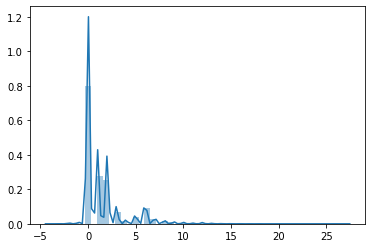

In [68]:
sns.distplot(y_train.flatten())

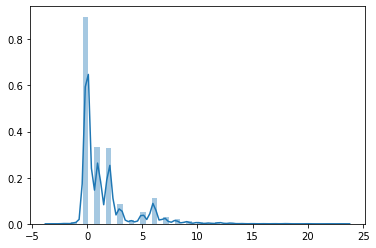

In [69]:
sns.distplot(y_dev.flatten())

True split after filtering:

In [70]:
total_examples = X_train.shape[0] + X_dev.shape[0] + X_test.shape[0]
print(f"Proportion training: {X_train.shape[0]/total_examples}")
print(f"Proportion dev: {X_dev.shape[0]/total_examples}")
print(f"Proportion test: {X_test.shape[0]/total_examples}")

Proportion training: 0.820683520330569
Proportion dev: 0.0990774484203277
Proportion test: 0.08023903124910327


### Define search space

In [81]:
SPACE = {
    'n_lstm_layers': hp.uniformint('n_lstm_layers', 1, 2),
    'lstm_units': hp.uniformint('lstm_units', 10, 200),
    'lstm_dropout': hp.quniform('lstm_dropout', low=0, high=0.5, q=0.01),
    'lstm_recurrent_dropout': hp.quniform('lstm_recurrent_dropout', low=0, high=0.5, q=0.01),
    'lstm_output_dropout': hp.quniform('lstm_output_dropout', low=0, high=0.5, q=0.01),
    'n_dense_layers': hp.uniformint('n_dense_layers', 0, 3),
    'dense_units': hp.uniformint('dense_units', 10, 500),
    'dense_dropout': hp.quniform('dense_dropout', low=0, high=0.5, q=0.01),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.5)),
    'batch_size': hp.uniformint('batch_size', 32, 4096)
}

INTEGER_PARAMS = ['n_lstm_layers', 'lstm_units', 'n_dense_layers', 'dense_units', 'batch_size']

In [82]:
from hyperopt.pyll.stochastic import sample

In [90]:
sample(SPACE)

{'batch_size': 2932,
 'dense_dropout': 0.16,
 'dense_units': 91,
 'learning_rate': 0.0002933772257864762,
 'lstm_dropout': 0.34,
 'lstm_output_dropout': 0.39,
 'lstm_recurrent_dropout': 0.05,
 'lstm_units': 46,
 'n_dense_layers': 0,
 'n_lstm_layers': 1}

In [73]:
def create_model(
    n_steps_in,
    n_steps_out,
    n_features,
    n_lstm_layers=1,
    lstm_units=50,
    lstm_dropout=0.0,
    lstm_recurrent_dropout=0.0,
    lstm_output_dropout=0.3,
    n_dense_layers=1,
    dense_units=50,
    dense_dropout=0.3
):
    model = Sequential(name='lstm_model')

    # LSTM layers
    if n_lstm_layers == 1:
        model.add(
            LSTM(
                units=lstm_units,
                dropout=lstm_dropout,
                recurrent_dropout=lstm_recurrent_dropout,
                input_shape=(n_steps_in, n_features),
                name='lstm_layer_1'
            )
        )
        model.add(
            Dropout(
                rate=lstm_output_dropout,
                name='lstm_layer_1_dropout'
            )
        )
    else:
        model.add(
            LSTM(
                units=lstm_units,
                dropout=lstm_dropout,
                recurrent_dropout=lstm_recurrent_dropout,
                return_sequences=True,
                input_shape=(n_steps_in, n_features),
                name='lstm_layer_1'
            )
        )
        for i in range(n_lstm_layers-1):
            model.add(
                LSTM(
                    units=lstm_units,
                    dropout=lstm_dropout,
                    recurrent_dropout=lstm_recurrent_dropout,
                    name=f'lstm_layer_{i+2}'
                )
            )
        model.add(
            Dropout(
                rate=lstm_output_dropout,
                name='lstm_multilayer_dropout'
            )
        )

    # Fully connected layers
    for i in range(n_dense_layers):
        model.add(Dense(dense_units, name=f'dense_layer_{i+1}'))
        model.add(BatchNormalization(name=f'dense_batch_norm_{i+1}'))
        model.add(Activation('relu', name=f'dense_activation_{i+1}'))
        model.add(Dropout(rate=dense_dropout, name=f'dense_dropout_{i+1}'))

    # Output layer
    model.add(Dense(
        n_steps_out, kernel_initializer=initializers.glorot_normal(), name='dense_output'
    ))

    return model

Use early stopping with patience of 20. Don't set limit of epochs.

In [75]:
def objective(hyperparameters):
    # Hacky workaround for bug in package which saves integer hyperparameters as floats in the final dictionary. We
    # explicitly cast as integers to avoid errors.
    for hyper in INTEGER_PARAMS:
        try:
            as_int = int(hyperparameters[hyper])
            hyperparameters[hyper] = as_int
        except:
            continue

    # Extract keys not needed for model creation
    fitting_params = {}
    fitting_params['learning_rate'] = hyperparameters['learning_rate']
    fitting_params['batch_size'] = hyperparameters['batch_size']

    del hyperparameters['learning_rate'], hyperparameters['batch_size']
    
    # Early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
    
    # Create model
    lstm_model = create_model(n_steps_in=N_STEPS_IN, n_steps_out=N_STEPS_OUT, n_features=60, **hyperparameters)

    # Compile model
    optimizer = optimizers.Adam(learning_rate=fitting_params['learning_rate'])
    lstm_model.compile(loss='mse', optimizer=optimizer)

    # Fit model
    lstm_model.fit(X_train, y_train, batch_size=fitting_params['batch_size'], verbose=0, callbacks=[es])

    # Evaluate on dev set (bootstrap)
    mse_list_new = []

    # Calculate bootstrap error
    for trial in range(100):
        idx = np.random.choice(X_dev.shape[0], size=X_dev.shape[0], replace=True)
        predictions = lstm_model.predict(X_dev[idx, :, :])

        mse = mean_squared_error(y_dev[idx], predictions)

        mse_list_new.append(mse)

    dev_error = np.mean(mse_list_new)

    return dev_error  # Has to be a minimisation problem

## RUN BELOW CELL IN COLAB

In [91]:
%%time
bayes_trials = Trials()
best = fmin(fn=objective, space=SPACE, algo=tpe.suggest, max_evals=30, trials=bayes_trials, rstate=np.random.seed(RANDOM_SEED))

  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

2020-08-14 17:09:51,565 - build_posterior_wrapper took 0.003836 seconds
2020-08-14 17:09:51,566 - TPE using 0 trials
/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning



 50%|█████     | 1/2 [00:48<00:48, 48.50s/trial, best loss: 5.86815675824123]

2020-08-14 17:10:40,392 - build_posterior_wrapper took 0.334246 seconds
2020-08-14 17:10:40,393 - TPE using 1/1 trials with best loss 5.868157
/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning



100%|██████████| 2/2 [01:40<00:00, 50.46s/trial, best loss: 5.2291565458418585]
CPU times: user 3min 35s, sys: 45.9 s, total: 4min 21s
Wall time: 1min 40s
